In [16]:
import pandas as pd
import numpy as np
import datetime as dt
from importlib import reload
import TSManager as ts
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')
%matplotlib inline

from CorrScreen import CorrScreenPredictor
import TSManager as ts

In [17]:
reload(ts)
mgr = ts.TSManager()
mgr.load()

Loading DP
Loading PE
Loading BM
Loading CAPE
Loading BY
Loading DEF
Loading PCAPrice
Loading CPI
Loading NOS
Loading PCR
Loading OIL
Loading SI
Loading BDI
Loading CAY
Loading IC
Loading TERM
Loading VRP
Loading SPX
Loading MA
Loading SIM
Loading RF


In [18]:
df = mgr.data
df.head()

,DP,PE,BM,CAPE,BY,DEF,PCAPrice,CPI,NOS,PCR,...,SI,BDI,CAY,IC,TERM,VRP,SPX,MA,SIM,RF
AsOfDate,,,,,,,,,,,,,,,,,,,,,
1990-06-08,0.063979,7.524271,NaN,8.978524,1.007418,0.96,3.616905,0.046737,0.016941,-1.622923,...,NaN,1278.0,-0.013576,NaN,0.50,7.197727,-0.012302,1,0.715385,NaN
1990-06-11,0.063463,7.597792,NaN,9.051612,1.009642,0.96,3.583706,0.046737,0.016941,-1.615366,...,NaN,1264.0,-0.013576,NaN,0.49,5.607431,0.008107,1,0.707692,NaN
1990-06-12,0.062662,7.699009,NaN,9.167251,1.009580,0.96,3.532720,0.046737,0.016941,-1.618868,...,NaN,1254.0,-0.013576,NaN,0.49,6.403252,0.012695,1,0.700000,NaN
1990-06-13,0.062894,7.674771,NaN,9.133460,1.000056,0.96,3.547245,0.046737,0.016941,-1.625316,...,NaN,1243.0,-0.013576,NaN,0.47,7.793147,-0.003693,1,0.692308,NaN
1990-06-14,0.063241,7.636994,NaN,9.083400,0.997689,0.96,3.569002,0.046737,0.016941,-1.620454,...,NaN,1232.0,-0.013576,NaN,0.46,7.665179,-0.005496,1,0.684615,NaN


/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


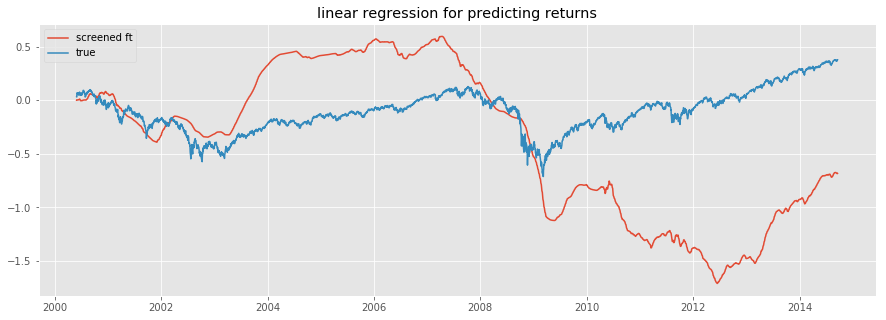

In [19]:
# test predictions

nbp = 180 # number of periods to be used
CSP = CorrScreenPredictor(df)
CSP.plot_predict(nbp)

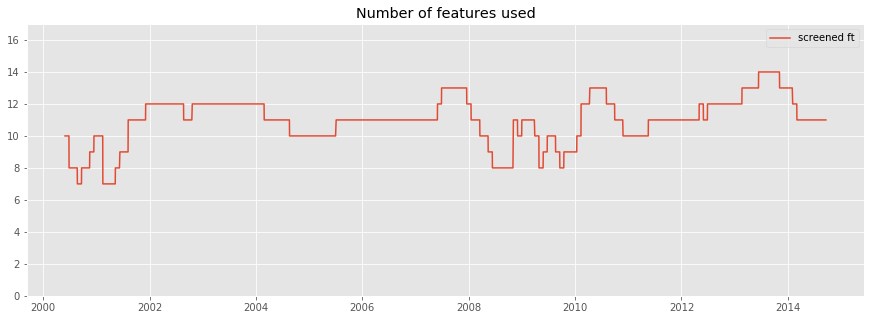

In [20]:
# plot total ft used per period

CSP.plot_screened_ft(nbp)

In [24]:
import handlers

class TradingBot:
    
    # index:             daily positions in SPX
    # update frequency:  positions are adjusted each time the return forecast change exceeds 10%
    # size:              eight times expected returns
    # caps:              strategy caped at 150% long / 50% short

    def __init__(self,data,threshold=0.1):
        self.threshold = threshold
        self.data = data
        self.X = np.array(data[[handle.NAME for handle in handlers.ALL_HANDLERS if handle.NAME != 'SPX']])
        self.y = np.array(data[['SPX']])
        rf = data['RF'][2520:].dropna().tolist()
        rf = filter(lambda s: s != '.', rf)
        self.rf = [float(s)*21*3/252 for s in rf]
        
        
    def _rf(self,nb_periods):
        #
        # used to compute equity risk premium (predicted_return - 90-day Treasury Bill)
        #
        return self.rf[:20*nb_periods]
    
    def CS_pos(self,nb_periods):
        
        #
        # computes positions for correlation screening
        #
        
        rf = self._rf(nb_periods)
        
        print(rf[:5])
    
        CSP = CorrScreenPredictor(self.data,self.threshold)
        __p,ytrue,sft = CSP.predict(nb_periods)
        
        _p = np.exp(__p)
        
        print(_p[:5])
        
        p = [_p[i]-rf[i] for i in range(len(_p))]
        
        
        
        plt.hist(p,bins=50)
        plt.title('predicted returns distribution')
        plt.show()
        
        
        pos = [8*p[0]]
        last_return_forecast = p[0]
        for k in range(1,len(p)):
            return_forecast = p[k]
            chg = return_forecast/last_return_forecast
            if (chg>=1.1) or (chg<=0.9):
                # change of 10% 
                last_return_forecast = return_forecast
            # take position
            pos.append(8*last_return_forecast)
            
        # cap positions
        for i in range(len(pos)):
            if pos[i]>1.5:
                pos[i]=1.5
            elif pos[i]<-0.5:
                pos[i]=-0.5
                
        return pos
    
    def plot_wealth_CS(self,nb_periods):
        
        # compute positions
        CS_pos = self.CS_pos(nb_periods)
        
        # timeline
        timeline = self.data.index[2520:(2520+nb_periods*20)]
        
        # spx buy and hold
        spx_buy_hold = np.exp(self.data['SPX'][2520:(2520+nbp*20)].cumsum())
        
        # strategy
        strat_rt = pd.DataFrame([1 + (pos[i] * (np.exp(df['SPX'][2520:(2520+nbp*20)][i]) - 1)) for i in range(len(pos))]).cumprod()
        
        # plot
        plt.figure(figsize=(15,5))
        plt.plot(timeline,strat_rt,label='Correlation Screening')
        plt.plot(timeline,spx_buy_hold,label='SPX buy and hold')
        plt.title('Comparison between strategy and SPX')
        plt.legend()
        plt.show()
    
            
        
        
        
    
    

[1.3924999999999998, 1.425, 1.43, 1.4549999999999998, 1.4375]
[0.99969526 0.99952376 1.0018162  1.00163783 1.00093619]


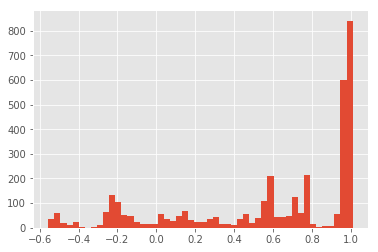

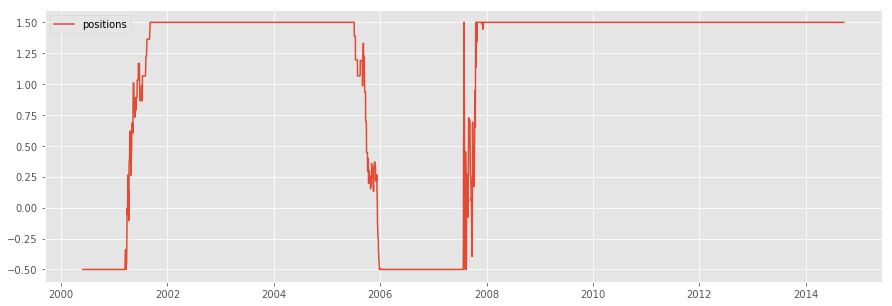

In [25]:
tb = TradingBot(df)

pos = tb.CS_pos(nbp)
plt.figure(figsize=(15,5))
plt.plot(df.index[2520:(2520+nbp*20)],pos,label='positions')
plt.legend()
plt.show()

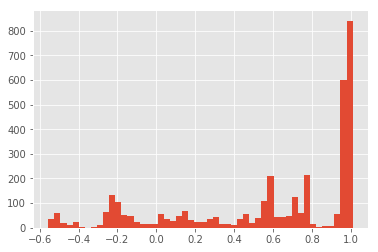

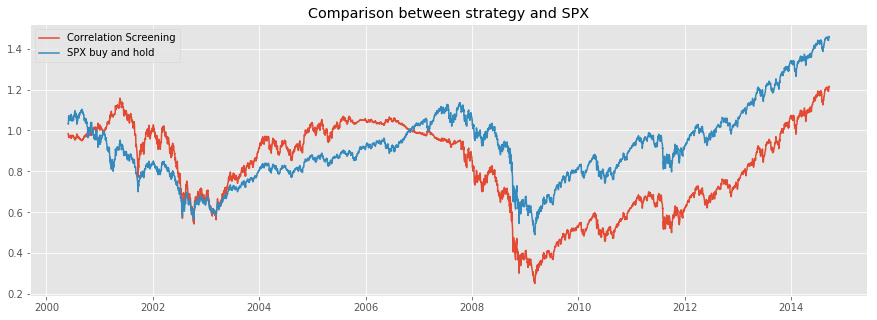

In [23]:
tb.plot_wealth_CS(nbp)